In [1]:
import sys
sys.path.append('../code')
import utils, spike_train_functions, lfp_functions

import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.io as sio
import pandas as pd
from bycycle import BycycleGroup
from bycycle.utils import get_extrema_df

from scipy.stats import wasserstein_distance
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

import seaborn as sns


In [2]:
# Set up file paths to load experimental data
mapping_dict = sio.loadmat('../data/RUS_map_MI_PMd.mat')
# session_name = 'RUSRH120619_MI_PMd_TT_KG_TC_NOGO_Ob001'
# session_name = 'RUSRH120622_MI_PMd_TT_KG_TC_NOGO_Ob001'
session_name = 'SPK121107_MI_PMd_TT_NOGO_ob001'


fpath = f'../data/{session_name}'
# unit_fname = f'{fpath}/{session_name}_DSXI_corrected_gNTSNR_split.mat'
unit_fname = f'{fpath}/{session_name}_DSXII-SORTED-01_gNTSNR.mat'

event_fname = f'{fpath}/{session_name}_ev_explicit'
lfp_fname = f'{fpath}/{session_name}_30x_downsample.mat'


In [3]:
# Load spiking data and electrode map
emap_dict = {'label_idx': np.stack(mapping_dict['map_struct'][0]['Num']).squeeze() - 1,
           'row': np.stack(mapping_dict['map_struct'][0]['Row']).squeeze(),
           'col': np.stack(mapping_dict['map_struct'][0]['Column']).squeeze(),
           'area': np.stack(mapping_dict['map_struct'][0]['SubArrayName']).squeeze()}
emap_df_full = pd.DataFrame(emap_dict)

single_unit_dict = sio.loadmat(unit_fname)

sorted_timestamps = single_unit_dict['sorted_timestamps'][0]
unit_timestamps = [sorted_timestamps[unit_idx].squeeze() for unit_idx in range(len(sorted_timestamps))]
num_units = len(unit_timestamps)
unit_names = np.array(range(num_units))

unit_electrodes = single_unit_dict['unit_index'][0,:] - 1
unit_areas = [emap_df_full['area'].values[elec_idx] for elec_idx in unit_electrodes]

In [4]:
# Load LFP data
samp_freq = 1000
nsx_dict = sio.loadmat(lfp_fname)
nsx_duration = nsx_dict['out'][0][0]['MetaTags'][0][0]['DataDurationSec']

lfp_data_raw = nsx_dict['out'][0][0]['Data']
lfp_times_raw = np.linspace(0, nsx_duration, lfp_data_raw.shape[1]).squeeze()

# Frequency filtering
N = 73
fs = samp_freq

b, a = scipy.signal.butter(3, [13,30], 'bandpass',fs=fs)
lfp_beta = scipy.signal.filtfilt(b, a, lfp_data_raw)

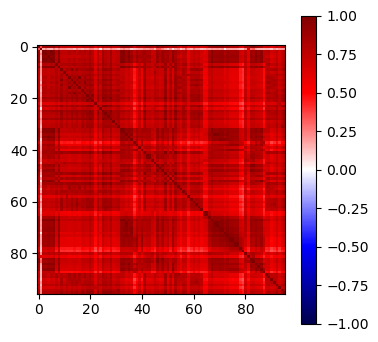

In [5]:
lfp_corr = np.corrcoef(lfp_data_raw)
plt.figure(figsize=(4,4))
plt.imshow(lfp_corr, cmap='seismic', interpolation='nearest', vmin=-1, vmax=1)
plt.colorbar()

In [7]:
# Load timestamps for task
experiment_dict = utils.load_cgid_ev_explicit(event_fname)

go = experiment_dict['go']
stmv = experiment_dict['stmv']
contact = experiment_dict['contact']
obpres = experiment_dict['obpres']
obj = experiment_dict['ob']
grip = experiment_dict['grip']
# grasppres = experiment_dict['grasppres']

# reaction_time = stmv - go


In [8]:
# event_dict = {'go': gocON, 'target': tgtON}
# window_dict = {'pre': (-win_len, win_len), 'post': (-win_len, win_len)}

win_start = -2.5
win_len = 2

# event_dict = {'go': go}
# window_dict = {'pre': (win_start, win_len)}

# event_dict = {'grasppres':grasppres, 'obpres': obpres}
event_dict = {'go': go}
window_dict = {'pre': (win_start, win_len)}


lfp_data_col = list()
lfp_beta_col = list()
event_col, event_times_col, window_col, tstart_col = list(), list(), list(), list()
trial_col, object_col, grip_col = list(), list(), list()

for window_name, (st_offset, max_time) in window_dict.items():
    max_samples = int(max_time * samp_freq)
    for event_name, event_ts in event_dict.items():
        object_col.extend(obj)
        grip_col.extend(grip)
        for trial_idx, event_time in enumerate(event_ts):
                event_col.append(event_name)
                event_times_col.append(event_time)
                window_col.append(window_name)
                trial_col.append(trial_idx)

                tstart = event_time + st_offset
                tstop = tstart + max_time
                start_idx = np.argmin(np.abs(lfp_times_raw - tstart))
                stop_idx = start_idx + max_samples
                
                tstart_col.append(tstart)

                lfp_windowed = lfp_data_raw[:, start_idx:stop_idx]
                lfp_data_col.append(lfp_windowed)
                
                lfp_beta_windowed = lfp_beta[:, start_idx:stop_idx]
                lfp_beta_col.append(lfp_beta_windowed)


lfp_dict = {'event': event_col, 'window': window_col, 'lfp': lfp_data_col, 'event_time': event_times_col,
            'object': object_col,
            'grip': grip_col, 'trial': trial_col, 'tstart': tstart_col,
            'lfp_beta': lfp_beta_col}

lfp_df = pd.DataFrame(lfp_dict)



In [9]:
# n_trials x n_channels x n_times
lfp_data_array = np.stack(lfp_df['lfp'].values)
z_lfp_data_array = scipy.stats.zscore(lfp_data_array, axis=1)

lfp_beta_array = np.stack(lfp_df['lfp_beta'].values)

# Z score across electrodes
z_lfp_beta_array = scipy.stats.zscore(lfp_beta_array, axis=1)

lfp_beta_hilbert = scipy.signal.hilbert(z_lfp_beta_array, axis=2)
lfp_beta_envelope = np.abs(lfp_beta_hilbert)
z_lfp_beta_envelope = scipy.stats.zscore(lfp_beta_envelope, axis=1)

lfp_beta_phase = np.angle(lfp_beta_hilbert)

In [10]:
num_trial_segs, num_channels, num_times = lfp_beta_envelope.shape
trial_idx_map = lfp_df['trial'].values # Need to grap actual trial indices
tstart_map = lfp_df['tstart'].values
event_map = lfp_df['event'].values
window_map = lfp_df['window'].values

x_times = np.linspace(0, num_times / samp_freq, num_times)

In [11]:
bycycle_lfp_array = np.transpose(lfp_data_array, (1,0,2))
fs = samp_freq
f_beta = (12,30)
n_seconds_beta = 0.75

thresholds = {'amp_fraction': 0.5, 'amp_consistency': .5, 'period_consistency': .4, 
              'monotonicity': .5, 'min_n_cycles': 2}

compute_kwargs = {'burst_method': 'cycles', 'threshold_kwargs': thresholds, 'center_extreme': 'trough'}


bg = BycycleGroup(thresholds=thresholds)
bg.fit(bycycle_lfp_array, fs, f_beta, axis=0, progress='tqdm')

# Combine to dataframe
bg_df_list = list()
assert len(bg.df_features) == num_channels
for channel_idx in range(num_channels):
    assert len(bg.df_features[channel_idx]) == num_trial_segs
    for trial_seg_idx in range(num_trial_segs):
        trial_idx = trial_idx_map[trial_seg_idx]
        trial_tstart = tstart_map[trial_seg_idx]
        event_name = event_map[trial_seg_idx]
        window_name = window_map[trial_seg_idx]
        
        
        temp_df = bg.df_features[channel_idx][trial_seg_idx].copy()
        temp_df['channel'] = np.repeat(channel_idx, len(temp_df))
        temp_df['trial'] = np.repeat(trial_idx, len(temp_df))
        temp_df['tstart'] = np.repeat(tstart, len(temp_df))
        temp_df['event'] = np.repeat(event_name, len(temp_df))
        temp_df['window'] = np.repeat(window_name, len(temp_df))
        temp_df['trial_seg'] = np.repeat(trial_seg_idx, len(temp_df))
        temp_df['grip'] = np.repeat(grip[trial_idx], len(temp_df))
        temp_df['object'] = np.repeat(obj[trial_idx], len(temp_df))

        bg_df_list.append(temp_df)
        
bg_df = pd.concat(bg_df_list)

# bg_df_combined.to_pickle('premovement_bycycle_df.pkl')
# pickle.dump(thresholds, open("premovement_bycycle_thresholds.pkl", "wb"))


Computing Bycycle Features: 100%|██████████| 96/96 [00:11<00:00,  8.21it/s]


In [12]:
# Most channels are highly correlated, easy way to identify noise outliers
noise_channels = np.where(np.mean(lfp_corr,axis=0) < 0.2)[0]
bg_df = bg_df[~np.isin(bg_df['channel'], noise_channels)]
clean_channels = bg_df['channel'].unique()
clean_channels

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95])

In [13]:
filter_df = bg_df.copy()
filter_df['sample_peak'] = (filter_df['sample_peak'] / fs) + filter_df['tstart']
filter_df['sample_last_trough'] = (filter_df['sample_last_trough'] / fs) + filter_df['tstart']
filter_df['sample_next_trough'] = (filter_df['sample_next_trough'] / fs) + filter_df['tstart']
filter_df = filter_df.dropna(axis=0)

# filter_df = filter_df[filter_df['is_burst']]
# filter_df = filter_df[filter_df['band_amp'] > 15]

wstart, wstop = -0.2, 0.2

st_data, st_data_cond1, st_data_cond2, st_data_go, st_data_stmv = list(), list(), list(), list(), list()
st_data_obpres, st_data_grasppres = list(), list()
for electrode_idx in clean_channels:
    electrode_df = filter_df.copy()
    electrode_df = electrode_df[electrode_df['channel']==electrode_idx]

    
    # Extract event ts for each electrode
    event_ts = electrode_df['sample_next_trough']

    filter_feature = 'amp_consistency'
    mask = electrode_df[filter_feature] > np.percentile(electrode_df[filter_feature].values, 50)
    event_ts_cond1 = electrode_df[mask]['sample_next_trough'].values
    event_ts_cond2 = electrode_df[~mask]['sample_next_trough'].values
    
    filter_units = np.where(unit_electrodes == electrode_idx)[0]
    filter_timestamps = [unit_timestamps[unit_idx] for unit_idx in filter_units]
    
    # Filter spike times to event ts
    filter_st_data = spike_train_functions.st_window_split(
        filter_timestamps, event_ts, wstart=wstart, wstop=wstop)
    
    filter_st_data_cond1 = spike_train_functions.st_window_split(
        filter_timestamps, event_ts_cond1, wstart=wstart, wstop=wstop)
        
    filter_st_data_cond2 = spike_train_functions.st_window_split(
        filter_timestamps, event_ts_cond2, wstart=wstart, wstop=wstop)
    
    filter_st_data_go = spike_train_functions.st_window_split(
        filter_timestamps, go, wstart=wstart, wstop=wstop)
    
    filter_st_data_stmv = spike_train_functions.st_window_split(
        filter_timestamps, stmv, wstart=wstart, wstop=wstop)
    
    st_data.extend(filter_st_data)
    st_data_cond1.extend(filter_st_data_cond1)
    st_data_cond2.extend(filter_st_data_cond2)
    st_data_go.extend(filter_st_data_go)
    st_data_stmv.extend(filter_st_data_stmv)


/home/ntolley/anaconda3/envs/sfn_2023/lib/python3.9/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


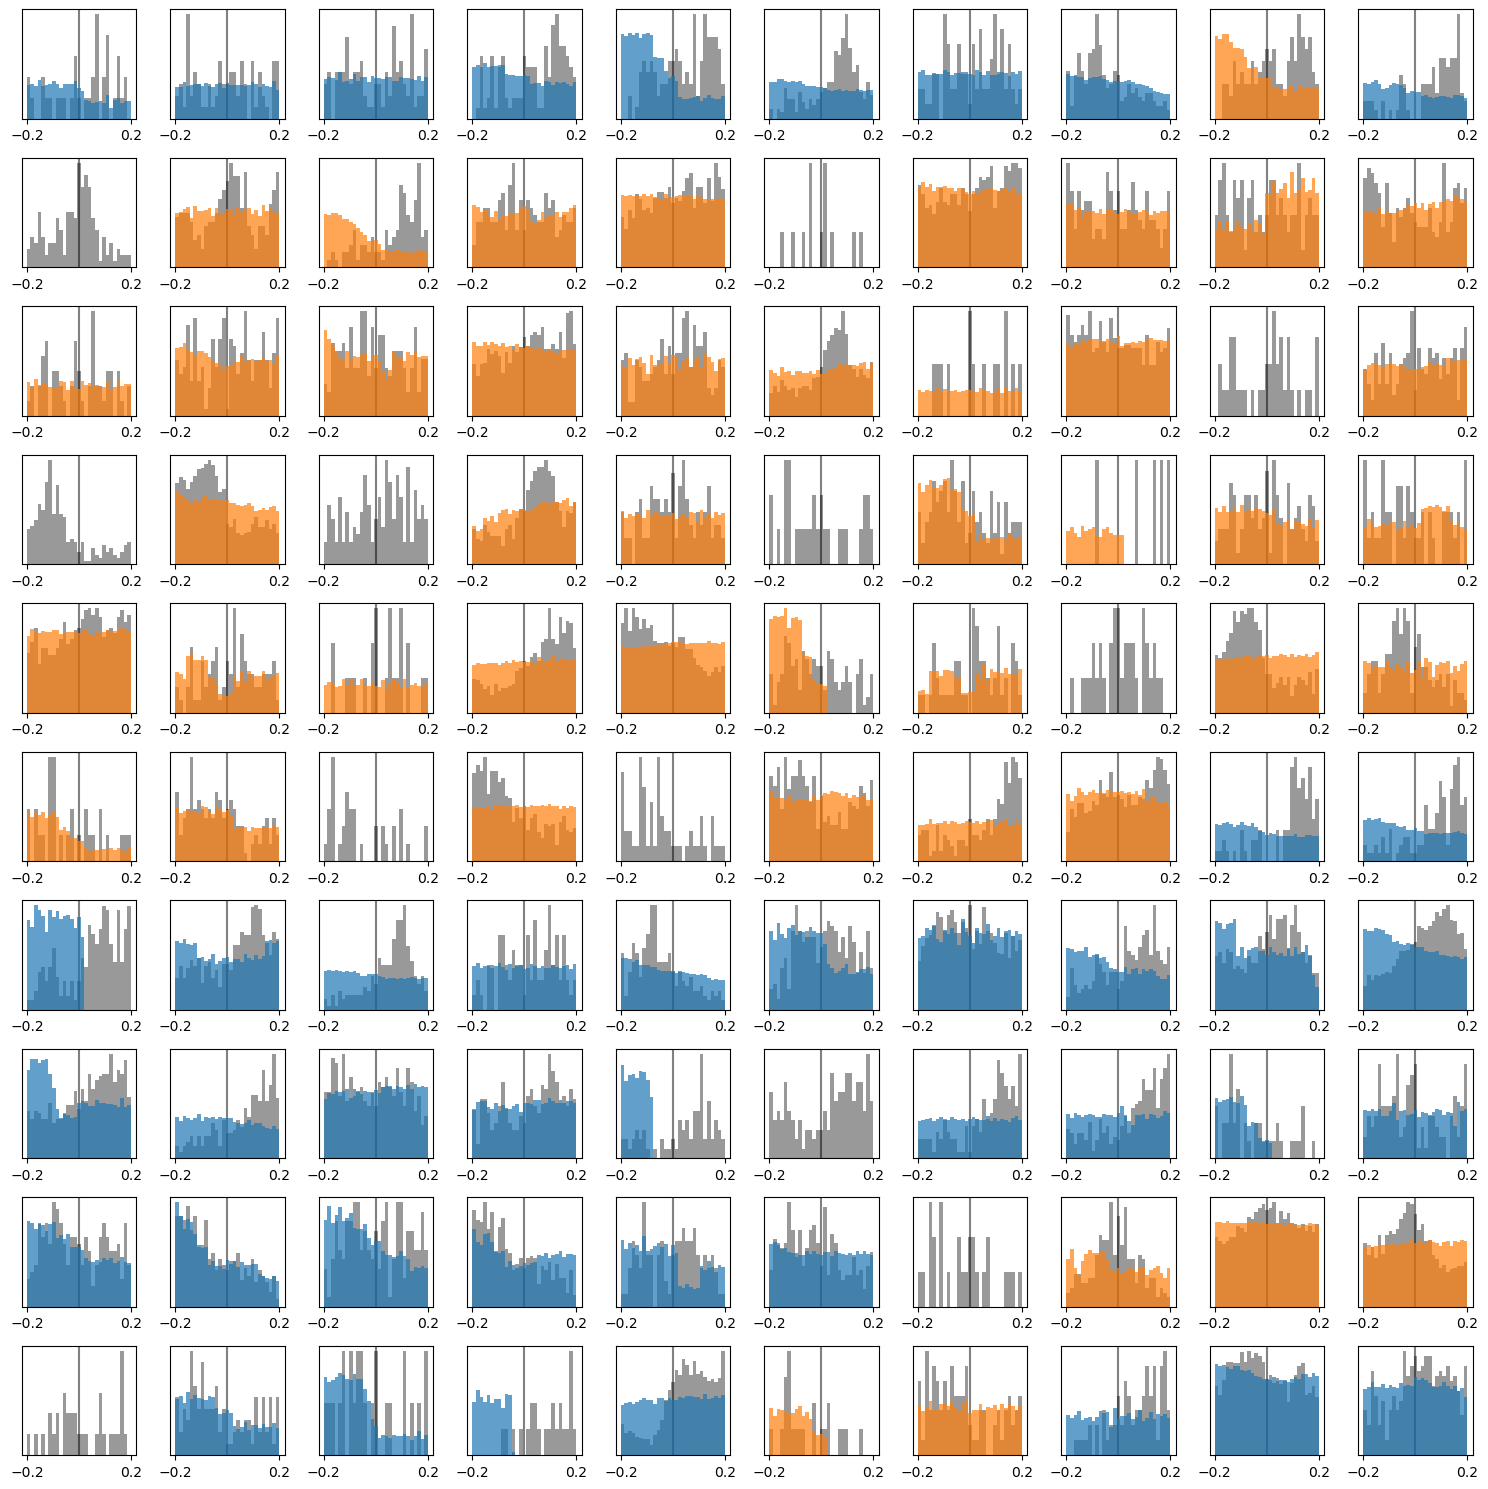

In [14]:
area_color = {'MI': 'C0', 'PMd': 'C1'}

bins = np.linspace(wstart, wstop, 30)
plt.figure(figsize=(15,15))
for plot_idx, unit_idx in enumerate(range(0, 100)):
    area = unit_areas[unit_idx]
    plt.subplot(10,10,plot_idx+1)
    _ = plt.hist(np.concatenate(st_data_stmv[unit_idx]) + wstart, bins=bins, alpha=0.4, density=True, color='k')
    _ = plt.hist(np.concatenate(st_data[unit_idx]) + wstart, bins=bins, alpha=0.7, density=True, color=area_color[area])
    
    # _ = plt.hist(np.concatenate(st_data_cond1[unit_idx]) + wstart, bins=bins, color='C0', alpha=0.7, density=True)
    # _ = plt.hist(np.concatenate(st_data_cond2[unit_idx]) + wstart, bins=bins, color='C1', alpha=0.7, density=True)
    
    plt.axvline(x=0, color='grey', zorder=-1100)
    plt.xticks([wstart, wstop])
    plt.yticks([])
plt.tight_layout()

In [15]:
st_hist_data = [np.concatenate(st_data[unit_idx]) for unit_idx in range(len(st_data))]
st_hist_data = [st_hist_data[unit_idx] for unit_idx in range(len(st_hist_data)) if len(st_hist_data[unit_idx]) > 0]
num_units = len(st_hist_data)

median_data = [np.median(st_hist_data[unit_idx]) for unit_idx in range(num_units)]
count_data = [len(st_hist_data[unit_idx]) for unit_idx in range(num_units)]

num_units = len(st_hist_data)

dist_mat = np.zeros((num_units, num_units))
for unit_idx1 in range(num_units):
    for unit_idx2 in range(unit_idx1, num_units):
        dist = wasserstein_distance(st_hist_data[unit_idx1], st_hist_data[unit_idx2])
        dist_mat[unit_idx1, unit_idx2] = dist
        dist_mat[unit_idx2, unit_idx1] = dist

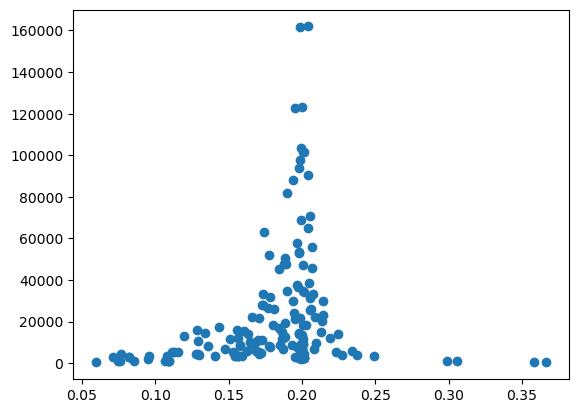

In [16]:
plt.scatter(median_data, count_data)

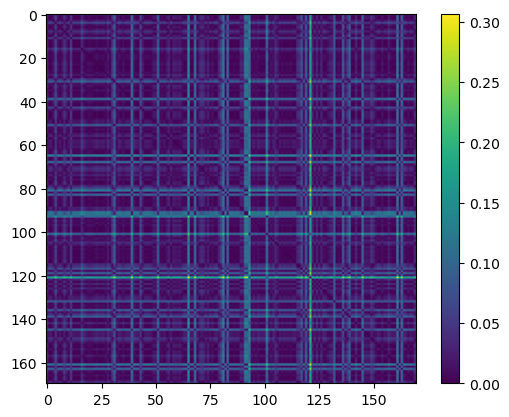

In [17]:
plt.imshow(dist_mat)
plt.colorbar()

In [18]:
model = TSNE(n_components=2, perplexity=10, metric='precomputed', init='random')
kmeans = KMeans(n_clusters=4)

points = model.fit_transform(dist_mat)
points_class = kmeans.fit_predict(points)

df_dict = {'TSNE1': points[:,0], 'TSNE2': points[:,1],
           'cluster': points_class.astype(str),
           'median': median_data, 'count': count_data}

df = pd.DataFrame(df_dict)

/home/ntolley/anaconda3/envs/sfn_2023/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Text(0, 0.5, 'TSNE2')

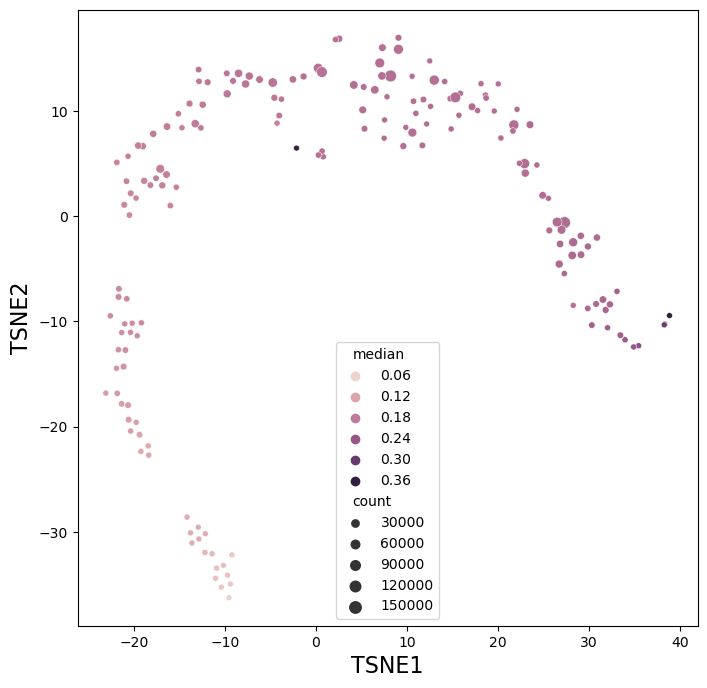

In [19]:
plt.figure(figsize=(8,8))
sns.scatterplot(data=df, x='TSNE1', y='TSNE2', hue='median', size='count')
plt.xlabel('TSNE1', fontsize=16)
plt.ylabel('TSNE2', fontsize=16)